# ELE 435/535 Lab 6

### Due Date : 11/11 Mon 11:59 PM

In [65]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Load MNIST Dataset 

We will be working with the subset of MNIST that was used for HW1 in this HW. The training data contains 10,000 samples of different digits. Let's call it matrix D (of dimension 784 * 10000). The first 1000 columns of D correspond to digit 0 ($D_0$), the next 1000 correspond to digit 1 ($D_1$), etc. 

In [66]:
train_data = np.load('MNISTcwtrain1000.npy')
train_data = train_data.astype(dtype='float64')
test_data = np.load('MNISTcwtest100.npy')
test_data = test_data.astype(dtype='float64')

train_data = train_data/255.0
test_data = test_data/255.0

### Q1) Collaborative Representation Based Classification Using Lasso

In a previous HW, we used least squares regression for classifiying data. Given any new example (x), we would like to represent it as a linear combination of columns of D (hence, the name representation based classification). This can be acheived by finding a vector w (of dimension 1,000) that satisfies: $w = \arg\min \hspace{1mm} \|Dw - x \|_2$.

The first 100 elements of w ($w_0$) quantify how much of each column from digit 0 are needed to represent x. Similarly, the next 100 elements ($w_1$) correspond to weights on $D_1$, etc.

Next, prediction of pixel values of any test image (x) based only on examples of a particual digit $i$ can be found using $y_i' = D_i \times w_i$. Then, k-th digit that yields the lowest mean squared prediction error (i.e., $k = \arg\min \hspace{1mm} \|y -y'_i \|_2$) will determine the label of x. 

Following this procedure to predict the labels of each test example, the testing accuracy is 0.76.

#### * Use reduced training set ($Xr$) and test set ($test$) defined below. This will save the running time.

In [67]:
Xr=np.zeros((784,1000))
test=np.zeros((784,100))
for ind in range(10):
    Xr[:,100*ind:100*(ind+1)] = train_data[:,1000*ind:1000*ind+100]
    test[:,10*ind:10*(ind+1)] = test_data[:,100*ind:100*ind+10]

In [68]:
# least square
X = np.matrix(Xr)
[U,sigma,V] = np.linalg.svd( X, full_matrices=False)
index = np.where(sigma>1e-4)
trunc = index[0][-1]
INV_Mat = np.linalg.pinv(np.dot(X.T,X))
Projection_Mat = INV_Mat * (X.T) 
predicted_label = np.zeros((100,))
for i in range(0,100):
    test_ex = np.matrix(test[:,i]).T
    p = Projection_Mat * test_ex
    dist = np.zeros((10,))
    for j in range(0,10):
        sub_mat = X[:,j*100:(j+1)*100]
        sub_W = p[j*100:(j+1)*100]
        reconstructed = np.dot(sub_mat, sub_W)
        dist[j] = np.linalg.norm(reconstructed - test_ex)
    predicted_label[i] = np.argmin(dist)
true_label = np.zeros((100,))
for i in range(0,10):
    true_label[i*10:(i+1)*10] = i
test_err = np.count_nonzero(predicted_label - true_label)
test_acc = 1-(test_err/100.0)

print("Test Accuacy :::::: " + str(test_acc))

Test Accuacy :::::: 0.76


Now, instead of using least square, we use LASSO in this question to find a sparse $w$. The idea behind is that we only want to use a small number of training samples to represent the test sample. Then, the objective is to find a vector $w$ that satisfies: $w = \arg\min \hspace{2mm} \|Dw - x \|_2 ^2 + \lambda \|w \|_1$. 

1.Try $\lambda = 10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 1, 10, 100$ and plot testing accuracy vs. $\lambda$. Compare the testing accuracy with that from least square. 

You can use the Lasso solver in Scikit-learn (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). Note that the objective function of Lasso solver in Scikit-learn might be different from what we defined here. Please adjust your arguments to the solver accordingly.

In [80]:
from sklearn import linear_model
from sklearn.linear_model import Lasso

In [81]:
# lambda vector 
lambda_vector = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 10, 100]
alpha_vector = np.true_divide(lambda_vector, 2*784)

In [84]:
accuracies = np.zeros(len(lambda_vector),)
avg =  np.zeros(len(lambda_vector),)
avg_nk = np.zeros(len(lambda_vector),)
nk_vector = np.zeros(len(lambda_vector),)

for k in range(len(lambda_vector)):
    
    sum_nonzero = 0
    sum_k_nonzero = 0
    
    lasso = Lasso(alpha=alpha_vector[k])

    #solve the lasso and compute accuracy 
    X = np.matrix(Xr)
    predicted_label = np.zeros((100,))
    
    count = 0
    for i in range(0,100):
        test_ex = np.matrix(test[:,i]).T
        lasso.fit(X,test_ex)
        p = np.zeros((1000,1))
        p[:,0] = lasso.coef_[:]
        
        sum_nonzero = sum_nonzero+np.count_nonzero(p)
        
        dist = np.zeros((10,))
        
        k_true_label = int(i // 10.0)
        sub_W_k = p[k_true_label*100:(k_true_label+1)*100]
        
        if np.count_nonzero(p) != 0:
            sum_k_nonzero = sum_k_nonzero + np.count_nonzero(sub_W_k)/float(np.count_nonzero(p[:,0]))
            count = count + 1
        
        for j in range(0,10):
            sub_mat = X[:,j*100:(j+1)*100]
            sub_W = p[j*100:(j+1)*100]
            reconstructed = np.dot(sub_mat, sub_W)
            dist[j] = np.linalg.norm(reconstructed - test_ex)
        predicted_label[i] = np.argmin(dist)
        
        
    print(count)    
    true_label = np.zeros((100,))
    for i in range(0,10):
        true_label[i*10:(i+1)*10] = i
    test_err = np.count_nonzero(predicted_label - true_label)
    test_acc = 1-(test_err/100.0)
    accuracies[k] = test_acc
    avg[k] = sum_nonzero/100
    avg_nk[k] = sum_k_nonzero/count
    
    
    print(test_acc)

100
0.26
100
0.27
100
0.27
100
0.44
100
0.83
100
0.93
100
0.93
69
0.59


[-0.5  -0.49 -0.49 -0.32  0.07  0.17  0.17 -0.17]


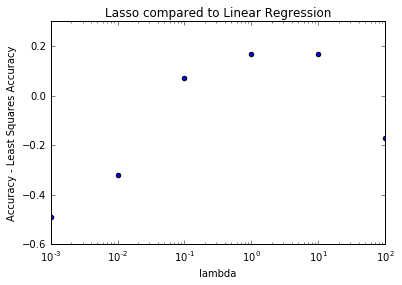

In [85]:
#compare with least squares (acc = 0.76)
print(accuracies - 0.76)
ax = plt.gca()
ax.scatter(lambda_vector, accuracies - 0.76)
ax.set_xscale('log')
ax.set_xlim([0.001, 100])
plt.xlabel('lambda')
plt.ylabel('Accuracy - Least Squares Accuracy')
plt.title('Lasso compared to Linear Regression')

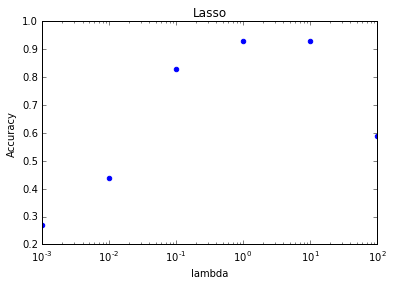

In [86]:
ax = plt.gca()
ax.scatter(lambda_vector, accuracies, color = (0,0,1))
ax.set_xscale('log')
ax.set_xlim([0.001, 100])
plt.xlabel('lambda')
plt.ylabel('Accuracy')
plt.title('Lasso')

2.Plot the average number of nonzero entries in $w$ vs. $\lambda$.

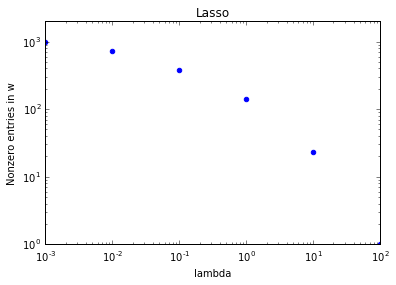

In [87]:
ax = plt.gca()
ax.scatter(lambda_vector, avg, color = (0,0,1))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.001, 100])
ax.set_ylim([0, 2000])
plt.xlabel('lambda')
plt.ylabel('Nonzero entries in w')
plt.title('Lasso')

3.For each test sample, suppose $k$ is the right label, define $nk$ as nonzeros in $w_k$ / total # nonzeros in $w$. Plot the average of $nk$ over all testing samples vs. $\lambda$. What do you find?

[ 0.1         0.099994    0.100548    0.1068525   0.12462098  0.17720669
  0.41309002  0.81183575]


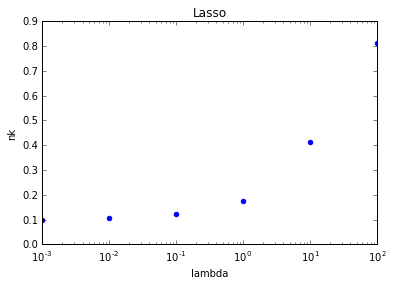

In [402]:
ax = plt.gca()
ax.scatter(lambda_vector, avg_nk, color = (0,0,1))
ax.set_xscale('log')
ax.set_xlim([0.001, 100])
plt.xlabel('lambda')
plt.ylabel('nk')
plt.title('Lasso')
print(avg_nk)

In [403]:
print("We observe that nk increases exponentially with lambda")

We observe that nk increases exponentially with lambda


### Q2) Collaborative Representation Based Classification Using Elastic Net

We now use the elastic net objective function to find $w$: $w = \arg\min \hspace{2mm} \|Dw - x \|_2 ^2 + \lambda (\alpha \|w \|_1+0.5(1-\alpha) \|w \|_2 ^2 )$. It linearly combines the $L1$ and $L2$ penalties. Choose an appropriate $\lambda$ from Q1, and vary $\alpha$ in the range $(0,1)$.

You can use Scikit-learn ElasticNet (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html). Refer to the documentation on the web.

4.Plot testing accuracy vs. $\alpha$. Compare the testing accuracy with that from least square and Lasso. 

In [92]:
from sklearn import linear_model
from sklearn.linear_model import ElasticNet

Num_points = 10
a_vector = np.linspace(0, 1, Num_points)
lambda_value = 5.0
n = 784
alpha_value = lambda_value/(2*n)

accuracies_enet = np.zeros(len(a_vector),)
avg_enet =  np.zeros(len(a_vector),)
avg_nk_enet = np.zeros(len(a_vector),)
nk_vector_enet = np.zeros(len(a_vector),)


for k in range(len(a_vector)):
    #from the previous part, we choose lambda to be lambda = 5.0
    l1_ratio_value = a_vector[k]
    
    sum_nonzero = 0
    sum_k_nonzero = 0
    
    enet = ElasticNet(alpha=alpha_value, l1_ratio=l1_ratio_value)

    #solve the elasticnet and compute accuracy 
    X = np.matrix(Xr)
    predicted_label = np.zeros((100,))
    count = 0
    for i in range(0,100):
        test_ex = np.matrix(test[:,i]).T
        enet.fit(X,test_ex)
        p = np.zeros((1000,1))
        p[:,0] = enet.coef_[:]
        
        sum_nonzero = sum_nonzero+np.count_nonzero(p)
        
        dist = np.zeros((10,))
        
        k_true_label = int(i // 10.0)
        sub_W_k = p[k_true_label*100:(k_true_label+1)*100]
        if np.count_nonzero(p) != 0:
            sum_k_nonzero = sum_k_nonzero + np.count_nonzero(sub_W_k)/float(np.count_nonzero(p[:,0]))
            count = count + 1
        
        for j in range(0,10):
            sub_mat = X[:,j*100:(j+1)*100]
            sub_W = p[j*100:(j+1)*100]
            reconstructed = np.dot(sub_mat, sub_W)
            dist[j] = np.linalg.norm(reconstructed - test_ex)
        predicted_label[i] = np.argmin(dist)
        
        
    true_label = np.zeros((100,))
    for i in range(0,10):
        true_label[i*10:(i+1)*10] = i
    test_err = np.count_nonzero(predicted_label - true_label)
    test_acc = 1-(test_err/100.0)
    
    accuracies_enet[k] = test_acc
    avg_enet[k] = sum_nonzero/100
    if count != 0:
        avg_nk_enet[k] = sum_k_nonzero/count
    
    
    print(test_acc)
    



0.84
0.93
0.94
0.94
0.94
0.93
0.95
0.95
0.95
0.94


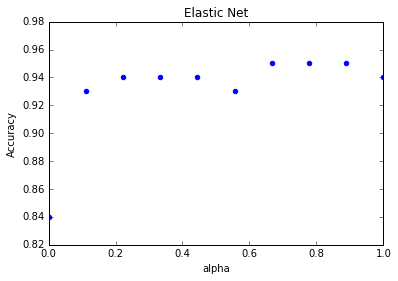

In [93]:
ax = plt.gca()
ax.scatter(a_vector, accuracies_enet, color = (0,0,1))
ax.set_xlim([0, 1])
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.title('Elastic Net')

In [94]:
#compare to linear regression
accuracies_enet - 0.76

array([ 0.08,  0.17,  0.18,  0.18,  0.18,  0.17,  0.19,  0.19,  0.19,  0.18])

In [95]:
#compare to lasso at lambda = 10
#compare to linear regression
accuracies_enet - accuracies[4]

array([ 0.01,  0.1 ,  0.11,  0.11,  0.11,  0.1 ,  0.12,  0.12,  0.12,  0.11])

5.Plot the average number of nonzero entries in $w$ vs. $\alpha$ and average $nk$ vs. $\alpha$. What do you find?

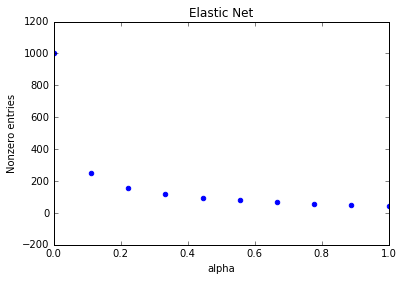

In [96]:
ax = plt.gca()
ax.scatter(a_vector, avg_enet, color = (0,0,1))
ax.set_xlim([0, 1])
plt.xlabel('alpha')
plt.ylabel('Nonzero entries')
plt.title('Elastic Net')

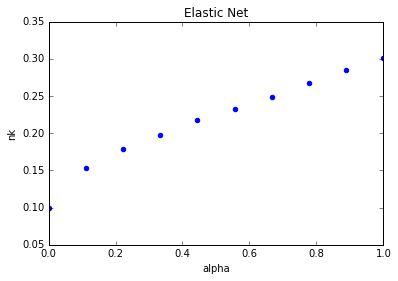

In [97]:
ax = plt.gca()
ax.scatter(a_vector, avg_nk_enet, color = (0,0,1))
ax.set_xlim([0, 1])
plt.xlabel('alpha')
plt.ylabel('nk')
plt.title('Elastic Net')

In [98]:
print("We observe that the number of nonzero entries also converge to 0 as alpha increases, but nk varies linearly positively with increases in alpha.")

We oobserve that the number of nonzero entries also converge to 0 as alpha increases, but nk varies linearly positively with increases in alpha.


### Q3) Orthogonal Matching Pursuit (OMP)

The general sparse least squares problem can be posed as below.
\begin{equation}
\min_{x\in\mathbb{R}^n} \|y-Ax\|_2^2
\end{equation}
\begin{equation}
\mbox{s.t.} \|x\|_0 \leq k 
\end{equation}

Orthogonal Matching Pursuit (OMP) is a greedy algorithm for sparse least squares problem above. Refer to the section 13.5.2 in the notes for the details.

X (train) : 100 x 512
y (test) : 100 x 1
w (weight) : 512 x 1


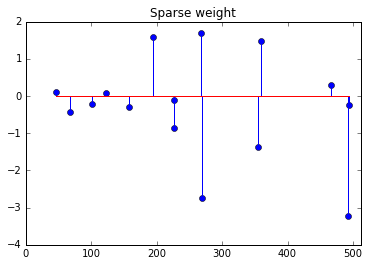

In [216]:
from sklearn import linear_model
from sklearn.datasets import make_sparse_coded_signal

y, X, w = make_sparse_coded_signal(n_samples=1,n_components=512,n_features=100,n_nonzero_coefs=15,random_state=0)
print 'X (train) : ' + str(X.shape[0]) + ' x ' + str(X.shape[1])
print 'y (test) : ' + str(y.shape[0]) + ' x 1'
print 'w (weight) : ' + str(w.shape[0]) + ' x 1'

idx, = w.nonzero()

plt.figure()
plt.stem(idx, w[idx])
plt.xlim([0,512])
plt.title('Sparse weight')
plt.show()

6.Use the orthogonal matching pursuit algorithm to find the $\hat{w}$ (coefficients) and compare it with the $w$ above (compute $\|w-\hat{w}\|_2^2$). (http://scikit-learn.org/stable/auto_examples/linear_model/plot_omp.html)

You can use scikit-learn OrthogonalMatchingPursuit (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.OrthogonalMatchingPursuit.html). Set $\mbox{n_nonzero_coefs}=20$, $\mbox{fit_intercept}=False$ and default for other parameters. 

In [217]:
from sklearn import linear_model
from sklearn.linear_model import OrthogonalMatchingPursuit
from numpy import linalg as LA

In [218]:
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=20, fit_intercept=False)

In [219]:
omp.fit(X,y)
w_coeff = omp.coef_
print(w_coeff.shape)

(512,)


In [377]:
from numpy import linalg as LA
print(LA.norm(w_coeff-w)**2)

6.37425033694e-30


7.Implement the OMP function yourself with following requirements. (Refer to the section 13.5.2 in the notes for the details of the algorithm.)

[Termination conditions]

1)Number of nonzero elements in $w$. 
\begin{equation}
\mbox{number of nonzero elements} = k
\end{equation}
2)Tolerance of the residual.
\begin{equation}
\frac{\|y-\hat{y}\|_2}{\|y\|_2} \leq \mbox{tolerance}
\end{equation}
3)Maximum number of iterations.

In [390]:
from numpy import linalg as LA

# Function outline
# initialize t = 0 
# S0 = 0
# A0 = []
# r0 = y

def omp(X,y,n_nonzero,tol,max_iter):
    stop = False
    
    #initialize
    r0 = y #initial residual
    w = [] #initial solution
    t = 0 #initial iteration
    S = [] #minimizer index

    #iteration
    while stop == False:
        #update the residual
        t = t + 1
        
        #select atom most correlated with residual 
        max_num = np.abs(np.dot(X.T,r0)).argmax()
        S.append(max_num)
        
        w1 = LA.lstsq(X[:,S],y)[0]
        w = np.zeros(X.shape[1])
        for i in range(len(S)):
            w[S[i]] = w1[i]
        r0 = y - np.dot(X,w)
        
        if np.count_nonzero(w)==n_nonzero:
            stop = True

        if LA.norm(r0)/LA.norm(y) <= tol:
            stop = True
        if t > max_iter:
            stop = True
            
    return w

8.Repeat question 6 using your OMP function. (Set parameters as $\mbox{n_nonzero}=15$,$\mbox{tol}=10^{-30}$,$\mbox{max_iter}=300$)

In [391]:
n_nonzero = 15
tol = 1e-30
max_iter = 300

w_opm = omp(X,y,n_nonzero,tol,max_iter)

In [392]:
from numpy import linalg as LA
print(LA.norm(w_opm - w)**2)

2.06380726911e-29


9.Try changing the tolerance value from $10^{-3}$ to $10^{-30}$ in log scale. 1)Plot the error ($\|w-\hat{w}\|_2^2$) vs. tolerance and 2)number of nonzero elements in $\hat{w}$ vs. tolerance. (Keep $\mbox{n_nonzero}=15$ and $\mbox{max_iter}=300$.)

In [393]:
Num_points = 100
tol_vector = np.linspace(-30, -3, Num_points)

In [394]:
error_vector = np.zeros((Num_points,))
nonzero_elements = np.zeros((Num_points,))

for i in range(len(tol_vector)):
    w_opm = omp(X,y,n_nonzero,10**(tol_vector[i]),max_iter)
    error_vector[i] = LA.norm(w_opm - w)**2
    nonzero_elements[i] = np.count_nonzero(w_opm)

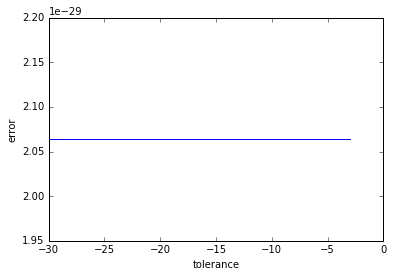

In [399]:
plt.plot(tol_vector, error_vector, color = (0,0,1))
plt.xlabel('tolerance')
plt.ylabel('error')

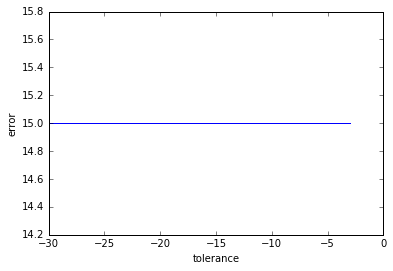

In [400]:
plt.plot(tol_vector, nonzero_elements, color = (0,0,1))
plt.xlabel('tolerance')
plt.ylabel('error')